<a href="https://colab.research.google.com/github/MichaelTay/w281-summer-2023-project/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

mountdir = '/content/drive/'
drive.mount(mountdir, force_remount=True)

localdir = mountdir + 'MyDrive'
w281_dir = '/Berkeley/w281/Fruit-and-Vegetable-Classification/modeling/pca_datasets/'
modeling_dir = localdir + w281_dir


Mounted at /content/drive/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os.path
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (roc_curve,
                             auc, RocCurveDisplay,
                             classification_report,
                             confusion_matrix,accuracy_score)
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LearningCurveDisplay,ShuffleSplit, learning_curve

from sklearn.metrics import accuracy_score, f1_score, make_scorer, ConfusionMatrixDisplay
from sklearn.utils import shuffle

from hyperopt import tpe, atpe, rand, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope
from tqdm import tqdm

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


In [6]:
!ls drive/MyDrive/Berkeley/w281/Fruit-and-Vegetable-Classification/modeling/pca_datasets

test_daisy_lum_sat_hue.csv	validation_daisy_lum_sat_hue.csv
training_daisy_lum_sat_hue.csv


## Modeling

##### Features: <br> Daisy, Hue, Saturation, Luminance, HOG, Laplacian.

In [3]:
train = pd.read_csv(modeling_dir + 'training_daisy_lum_sat_hue.csv').drop('Unnamed: 0', axis=1)
validation = pd.read_csv(modeling_dir + 'validation_daisy_lum_sat_hue.csv').drop('Unnamed: 0', axis=1)
test = pd.read_csv(modeling_dir + 'test_daisy_lum_sat_hue.csv').drop('Unnamed: 0', axis=1)

In [6]:
print(train.shape)
print(validation.shape)
print(test.shape)

(1535, 201)
(187, 201)
(187, 201)


### Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (roc_curve,
                             auc, RocCurveDisplay,
                             classification_report,
                             confusion_matrix,accuracy_score)
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score, f1_score, make_scorer, ConfusionMatrixDisplay
from sklearn.utils import shuffle

from hyperopt import tpe, atpe, rand, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope
from tqdm import tqdm

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Learning Curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Generate a simple plot of the learning curve.

    Parameters:
        estimator: The machine learning model or pipeline.
        title: The title of the plot.
        X: The feature matrix.
        y: The target vector.
        ylim: Tuple with (min, max) values to define the y-axis limits.
        cv: Cross-validation strategy. If None, 5-fold cross-validation is used.
        n_jobs: Number of jobs to run in parallel (-1 uses all available processors).
        train_sizes: Array of training set sizes to use for the learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(
        train_sizes,
        train_scores_mean,
        "o-",
        color="r",
        label="Training score",
    )
    plt.plot(
        train_sizes,
        test_scores_mean,
        "o-",
        color="g",
        label="Cross-validation score",
    )
    plt.legend(loc="best")
    return plt

#### Bayesian Parameter Search

In [32]:
space = {
    # 'C' : hp.loguniform('C', low=-4*np.log(10), high=4*np.log(10)),
    'C' : hp.uniform('C', 0.0001, 1000),
    'class_weight' : hp.choice('class_weight', ['balanced', None]),
    'max_iter' : hp.choice('max_iter', range(100,300)),
    'solver' : hp.choice('solver', ['lbfgs', 'sag', 'saga'])
}

In [7]:
X_train = train.iloc[:,0:-1]
y_train = train.iloc[:, -1]

In [34]:
def optimize_lr(params):

    skf = StratifiedKFold(n_splits=10)
    clf = LogisticRegression(**params,
                             n_jobs=-1)
    f1_weighted = cross_val_score(clf, X_train, y_train,
                         scoring=make_scorer(accuracy_score),
                        cv=skf).mean()
    best_score = np.mean(f1_weighted)
    loss = 1 - best_score
    return {"loss":loss, "status":STATUS_OK}

In [35]:
RANDOM_SEED = 4321
trials = Trials()

best = fmin(
    fn=optimize_lr,
    space=space,
    algo=tpe.suggest,
    # algo=atpe.suggest,
    # algo=rand.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(RANDOM_SEED)
)

print("Best: {}".format(best))

100%|██████████| 100/100 [1:37:00<00:00, 58.21s/trial, best loss: 0.743964858670741]
Best: {'C': 158.803615186731, 'class_weight': 1, 'max_iter': 74, 'solver': 2}


In [ ]:
from google.colab import runtime
runtime.unassign()

In [5]:
# plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5))
params = {'C': 158.803615186731, 'max_iter': 74, 'solver': 'saga', 'class_weight': None}
lr_model = LogisticRegression(**params)


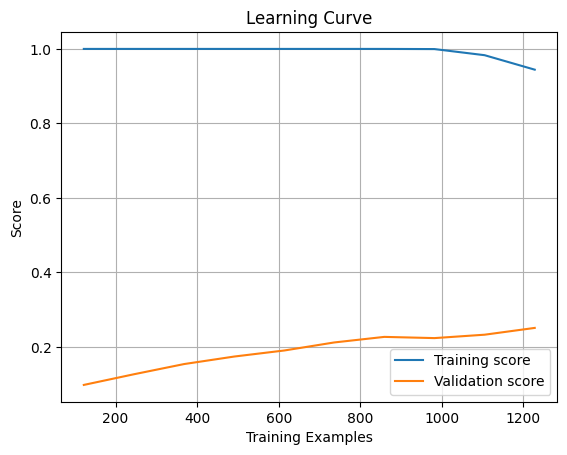

In [8]:

# For the sake of demonstration, we'll use synthetic data
# X = np.random.rand(100, 5)
# y = (X[:, 0] + X[:, 1] > 1).astype(int)  # Simple decision boundary for binary classification
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Create the learning curve
train_sizes, train_scores, val_scores = learning_curve(
    LogisticRegression(),  # Replace this with your desired model
    X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy'
)

# Step 4: Plot the learning curve
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.grid()
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, val_scores_mean, label='Validation score')
plt.legend(loc='best')
plt.show()


#### Inference

In [9]:
X_test, y_test = test.iloc[:, 0:-1], test.iloc[:, -1]

In [10]:
params = {'C': 0.0009555629172014686,
          'max_iter': 181,
          'solver': 'lbfgs',
          'class_weight': None}

lr_final_model = LogisticRegression(**params, n_jobs=-1)
lr_final_model.fit(X_train, y_train)

y_pred = lr_final_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.10160427807486631


In [11]:
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

        apple       0.00      0.00      0.00         9
       banana       0.00      0.00      0.00         9
  bell pepper       0.07      0.11      0.09         9
      cabbage       0.00      0.00      0.00        10
  cauliflower       0.33      0.33      0.33         9
chilli pepper       0.00      0.00      0.00         7
         corn       0.00      0.00      0.00        10
       garlic       0.14      0.20      0.17        10
       ginger       0.09      0.10      0.10        10
       grapes       0.33      0.38      0.35         8
         kiwi       0.14      0.10      0.12        10
        mango       0.11      0.10      0.11        10
       orange       0.00      0.00      0.00         7
         pear       0.00      0.00      0.00        10
         peas       0.12      0.11      0.12         9
    pineapple       0.18      0.20      0.19        10
  pomegranate       0.00      0.00      0.00        10
      spi

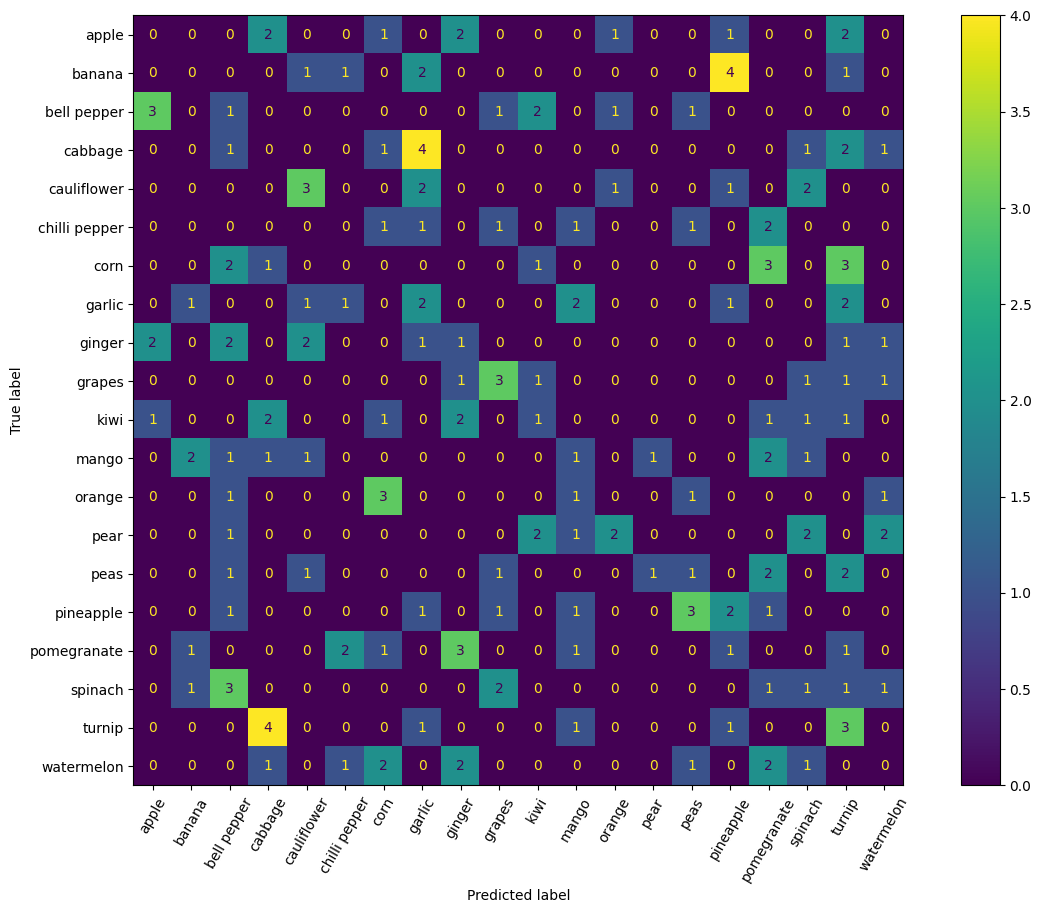

In [12]:
fig, ax = plt.subplots(figsize=(15,10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation=60, ax=ax)